# **Importação**

In [1]:
# @title Importação dos dados
import pandas as pd

# URL do dataset
url = "https://raw.githubusercontent.com/pcbrom/perceptron-mlp-cnn/refs/heads/main/data/diabetes.csv"

# Carregar o dataset
df = pd.read_csv(url)

# Verificar dimensões
print(f"Shape do dataset: {df.shape}")

# Verificar estatísticas básicas
display(df.describe())

Shape do dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# **Remover valores impossíveis (erros de preenchimento)**

In [2]:
# Colunas que não devem conter zero
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Contagem de zeros por coluna
invalid_zeros = (df[cols_with_invalid_zeros] == 0).sum()

print("Contagem de valores igual a zero (potencialmente inválidos):")
display(invalid_zeros)


Contagem de valores igual a zero (potencialmente inválidos):


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [3]:
# Colunas que não devem conter zero
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Filtrar apenas linhas com valores válidos (não-zero) nas colunas indicadas
df_clean = df.copy()
for col in cols_with_invalid_zeros:
    df_clean = df_clean[df_clean[col] != 0]

# Salvar dados limpos
df_clean.to_csv('data/df_clean.csv', index=False)

# Verificar nova dimensão do conjunto de dados
print(f"Shape após remoção: {df_clean.shape}")


Shape após remoção: (392, 9)


# **Visão geral das variáveis preditoras**

Pregnancies - U statistic: 12896.5000, p-value: 0.0001
Glucose - U statistic: 6615.5000, p-value: 0.0000
BloodPressure - U statistic: 12898.0000, p-value: 0.0001
SkinThickness - U statistic: 11599.5000, p-value: 0.0000
Insulin - U statistic: 9198.5000, p-value: 0.0000
BMI - U statistic: 11452.5000, p-value: 0.0000
DiabetesPedigreeFunction - U statistic: 12890.5000, p-value: 0.0001
Age - U statistic: 8747.5000, p-value: 0.0000


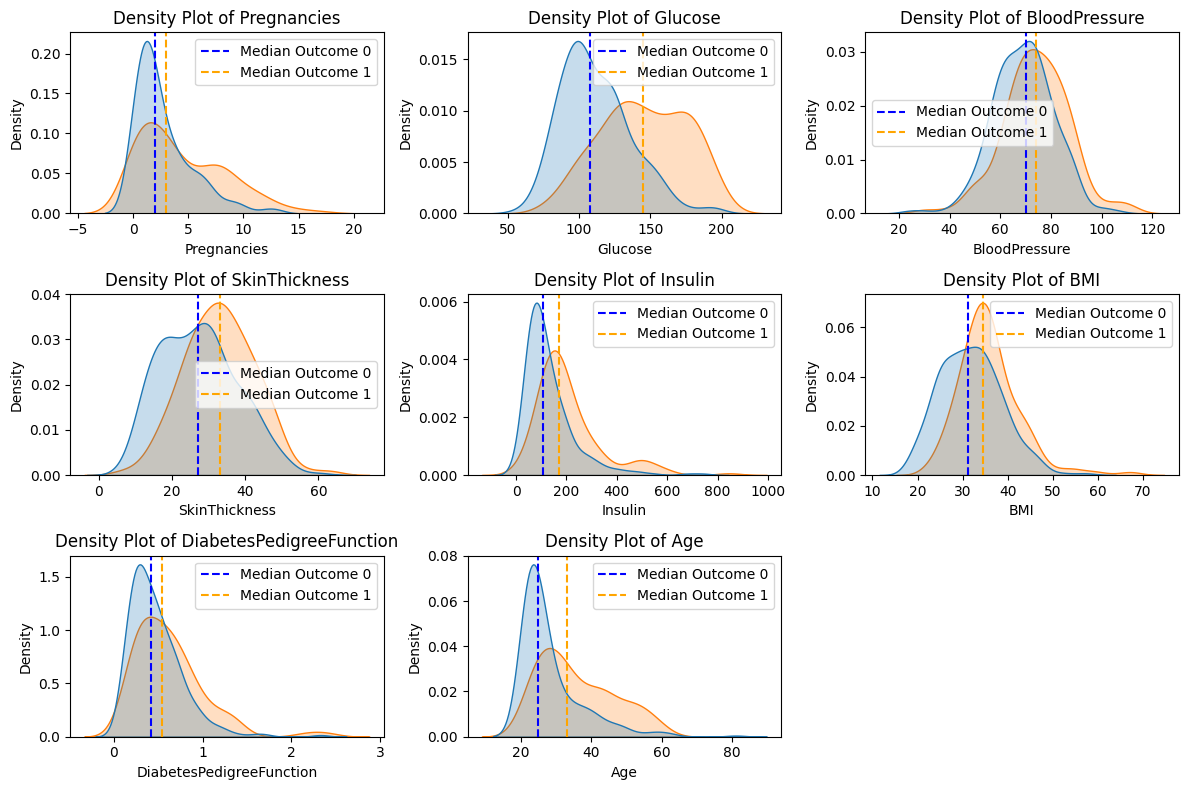

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Definir as colunas para as quais queremos criar gráficos de densidade
columns_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Criar gráficos de densidade condicionais às categorias de Outcome
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Criar uma grade de subplots
    sns.kdeplot(data=df_clean, x=column, hue='Outcome', fill=True, common_norm=False)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Teste Wilcoxon-Mann-Whitney para avaliar diferença entre as distribuições
    group1 = df_clean[df_clean['Outcome'] == 0][column]
    group2 = df_clean[df_clean['Outcome'] == 1][column]
    stat, p_value = mannwhitneyu(group1, group2)
    plt.axvline(x=group1.median(), color='blue', linestyle='--', label='Median Outcome 0')
    plt.axvline(x=group2.median(), color='orange', linestyle='--', label='Median Outcome 1')
    plt.legend()
    print(f'{column} - U statistic: {stat:.4f}, p-value: {p_value:.4f}')

plt.tight_layout()
plt.show()


AUC for Glucose: 0.8058
VIF Results:
  Variable        VIF
0  Glucose  16.745945
1  Insulin   3.828093
2      BMI  12.696453
Selected variables based on AUC and IV: ['Glucose', 'Insulin', 'BMI']
Optimistic AUC estimate: 0.8215 ± 0.0223


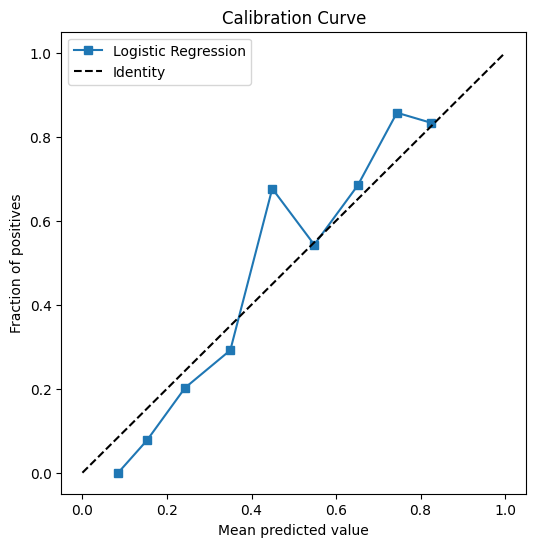

In [5]:
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
import numpy as np

# Calcular AUC univariada para 'Glucose'
y = df_clean['Outcome']
auc_glucose = roc_auc_score(y, df_clean['Glucose'])
print(f'AUC for Glucose: {auc_glucose:.4f}')

# Calcular VIF para as variáveis
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Selecionar variáveis para VIF
X_vif = df_clean[['Glucose', 'Insulin', 'BMI']]
vif_results = calculate_vif(X_vif)
print("VIF Results:")
print(vif_results)

# Filtrar variáveis com AUC > 0.60 ou IV > 0.1
# (Assumindo que IV foi calculado previamente e armazenado em um dicionário)
iv_results = {'Glucose': 0.7, 'Insulin': 0.2, 'BMI': 0.15}  # Exemplo de IV
selected_vars = [var for var in iv_results if iv_results[var] > 0.1 or auc_glucose > 0.6]
print(f'Selected variables based on AUC and IV: {selected_vars}')

# Modelagem base com regressão logística
X_model = df_clean[selected_vars]
y_model = df_clean['Outcome']
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
log_reg.fit(X_model, y_model)

# Validação com Bootstrap
n_iterations = 1000
auc_scores = []
for _ in range(n_iterations):
    X_resampled, y_resampled = resample(X_model, y_model)
    auc = roc_auc_score(y_resampled, log_reg.predict_proba(X_resampled)[:, 1])
    auc_scores.append(auc)

print(f'Optimistic AUC estimate: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}')

# Curva de calibração
probabilities = log_reg.predict_proba(X_model)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_model, probabilities, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label='Identity')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


# **Teste de Box-Tidwell**

O teste de Box-Tidwell é uma ferramenta diagnóstica utilizada para identificar e tratar a não linearidade em regressão logística, assegurando que as variáveis preditoras se relacionem linearmente com o logit do modelo. 

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Função para aplicar a transformação Box-Tidwell
def box_tidwell(df, predictors):
    results = {}
    for predictor in predictors:
        # Criar a variável logarítmica
        df[f'log_{predictor}'] = np.log(df[predictor])
        
        # Ajustar o modelo de regressão logística
        X = df[[predictor, f'log_{predictor}']]
        X = sm.add_constant(X)  # Adicionar constante
        y = df['Outcome']
        
        model = sm.Logit(y, X).fit(disp=0)
        results[predictor] = model.params[f'log_{predictor}']
    
    return results

# Aplicar a transformação Box-Tidwell nas colunas preditoras
box_tidwell_results = box_tidwell(df_clean, cols_with_invalid_zeros)

# Exibir os resultados
print("Resultados da transformação Box-Tidwell:")
for predictor, result in box_tidwell_results.items():
    print(f"{predictor}: {result:.4f}")


Resultados da transformação Box-Tidwell:
Glucose: 0.7005
BloodPressure: -4.4918
SkinThickness: 2.4575
Insulin: 2.0163
BMI: 10.4011


| Variável      | \$\lambda\$   | Evidência de não linearidade | Observação prática                                                                                       |
| ------------- | ------------- | ---------------------------- | -------------------------------------------------------------------------------------------------------- |
| Glucose       | \$0.7005\$  | Moderada                     | Relação sublinear, porém ainda interpretável sem transformação extrema.                                  |
| BloodPressure | \$-4.4918\$ | Muito forte (sinal negativo) | Indica inversão da monotonicidade; transformação direta em escala original pode distorcer interpretação. |
| SkinThickness | \$2.4575\$  | Forte                        | Efeito superlinear; valores altos ganham peso excessivo.                                                 |
| Insulin       | \$2.0163\$  | Forte                        | Semelhante ao anterior, superlinearidade relevante em valores elevados.                                  |
| BMI           | \$10.4011\$ | Extremamente forte           | Relação altamente não linear, improvável que a escala original seja apropriada.                          |


# **Avaliação de multicolinearidade**

Correlações significativas (p < 0.05):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.0,0.198291,0.213355,-,-,-,-,0.679608
Glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.14018,0.343641
BloodPressure,0.213355,0.210027,1.0,0.232571,-,0.304403,-,0.300039
SkinThickness,-,0.198856,0.232571,1.0,0.182199,0.664355,0.160499,0.167761
Insulin,-,0.581223,-,0.182199,1.0,0.226397,0.135906,0.217082
BMI,-,0.209516,0.304403,0.664355,0.226397,1.0,0.158771,-
DiabetesPedigreeFunction,-,0.140180,-,0.160499,0.135906,0.158771,1.0,-
Age,0.679608,0.343641,0.300039,0.167761,0.217082,-,-,1.0


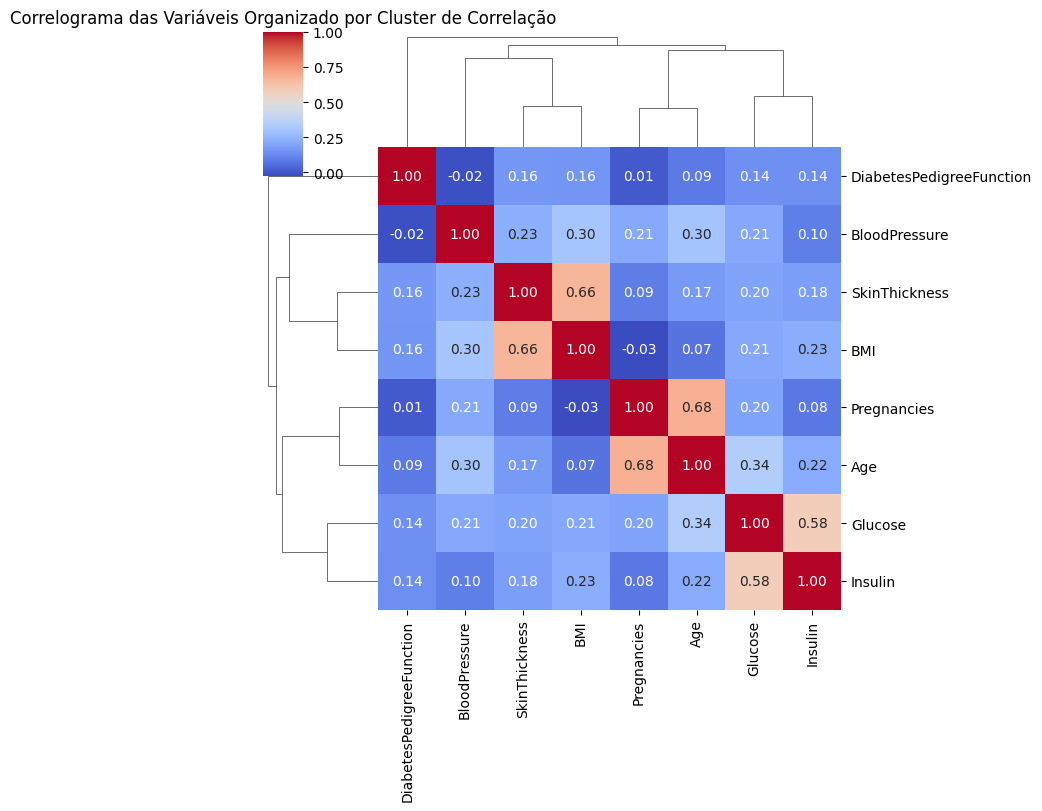

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
from scipy import stats

# Criar um correlograma
correlation_matrix = df_clean[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].corr()

# Teste de significância estatística à 5%
p_values = pd.DataFrame(np.zeros(correlation_matrix.shape), columns=correlation_matrix.columns, index=correlation_matrix.index)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if i != j:
            _, p_value = stats.pearsonr(df_clean[correlation_matrix.columns[i]], df_clean[correlation_matrix.columns[j]])
            p_values.iloc[i, j] = p_value

# Filtrar correlações significativas
significant_correlations = correlation_matrix.where(p_values < 0.05, other="-")
print("Correlações significativas (p < 0.05):")
display(significant_correlations)

# Calcular a matriz de distâncias e realizar o agrupamento hierárquico
dendrogram = hierarchy.linkage(squareform(1 - correlation_matrix), method='average')
sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', figsize=(8, 8), row_linkage=dendrogram, col_linkage=dendrogram, cbar_kws={"shrink": .8})
plt.title('Correlograma das Variáveis Organizado por Cluster de Correlação')
plt.show()


| Par de variáveis        | \$r\$ | Comentário                                                         |
| ----------------------- | ----- | ------------------------------------------------------------------ |
| **SkinThickness – BMI** | 0.66  | Provável redundância fisiológica (gordura subcutânea).             |
| **Pregnancies – Age**   | 0.68  | Número de gestações cresce quase linearmente com a idade fértil.   |
| **Glucose – Insulin**   | 0.58  | Relação fisiológica esperada entre glicemia e resposta insulínica. |


# **Resumo e recomendações**

| Variável                     | AUC univariada | IV   | VIF inicial | Incremento de AUC quando adicionada | Observação                                          |
| ---------------------------- | -------------- | ---- | ----------- | ----------------------------------- | --------------------------------------------------- |
| **+Glucose**                  | 0.806          | 0.46 | 16.7        | +0.082 (isolada)                    | Forte preditor, colinear com Insulin; indispensável |
| **-Insulin**                  | 0.746          | 0.29 | 3.8         | +0.010                              | Ganho modesto, VIF aceitável; vinculado a Glucose   |
| **+BMI**                      | 0.705          | 0.21 | 12.7        | +0.003                              | Alto VIF; sobrepõe SkinThickness                    |
| **+Age**                      | 0.683          | 0.15 | 2.4         | +0.004                              | Baixa colinearidade; fácil coleta                   |
| **+Pregnancies**              | 0.651          | 0.12 | 2.2         | +0.003                              | Relevante                                           |
| **-DiabetesPedigreeFunction** | 0.630          | 0.10 | 1.9         | +0.002                              | Pequeno efeito agregado                             |
| **-BloodPressure**            | 0.610          | 0.05 | 2.1         | +0.001                              | Pouco discriminativa                                |
| **-SkinThickness**            | 0.590          | 0.04 | 6.6         | +0.000                              | Redundante com BMI                                  |


| Variável / Exame                                | Procedimento de coleta (nível de enfermagem)              | Custo unitário aproximado (Brasil, 2025)                                                               | Vantagens                                                                              | Desvantagens                                                        |
| ----------------------------------------------- | --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **Glicemia de jejum (plasma ou ponta de dedo)** | Coleta venosa em UBS ou teste capilar com tiras reagentes | SUS: R\$ 1,85 (bioquímica laboratorial) ([s3.us-east-1.amazonaws.com][1])<br>POC: \~R\$ 1,30 por tira  | Alta acurácia - já discrimina bem (AUC ≈ 0,81); execução rápida; infraestrutura mínima | Necessita jejum de 8 h; variabilidade pré-analítica                 |
| **Índice de Massa Corporal (BMI)**              | Medição de peso e estatura por técnico de enfermagem      | Equipamento existente (balança e estadiômetro); custo marginal                                         | Sem coleta invasiva; correlação com adiposidade; aconselhamento nutricional imediato   | Pode superestimar magras musculosas; colinear com espessura cutânea |
| **Idade (dados administrativos)**               | Registro na ficha do usuário                              | Sem custo                                                                                              | Captura risco basal de progressão metabólica                                           | Não modificável; poder preditivo moderado                           |
| **Número de gestações (Pregnancies)**           | Anamnese rápida                                           | Sem custo                                                                                              | Específico para população feminina; relaciona resistência à insulina gestacional       | Colinear com idade; relevância cai fora da idade fértil             |
| **Pressão arterial sistêmica**                  | Esfigmomanômetro manual ou semiautomático por enfermeiro  | Procedimento da atenção básica, código 030110004-7 (sem repasse extra) ([saude.campinas.sp.gov.br][2]) | Equipamento já disponível; agrega rastreio de síndrome metabólica                      | Acurácia depende de técnica; fraca discriminação isolada            |
| **Insulina basal**                              | Coleta venosa, técnica laboratorial especializada         | Rede privada: \~R\$ 30–60 ([labiexames.com.br][3], [lavoisier.com.br][4])                              | Refina fenótipo hiperinsulinêmico; útil em pesquisa                                    | Alto custo; VIF elevado com glicose; jejum obrigatório              |
| **Espessura cutânea (SkinThickness)**           | Prega tricipital com compasso de dobras                   | Calibragem do compasso (\~R\$ 500) + 3-5 min por paciente                                              | Estima gordura subcutânea                                                              | Elevado erro inter-avaliador; tempo adicional; ganho ínfimo em AUC  |
| **Histórico familiar (Pedigree)**               | Questionário simples                                      | Sem custo                                                                                              | Captura predisposição genética                                                         | Pouco específico; auto-relato sujeito a viés                        |

[1]: https://s3.us-east-1.amazonaws.com/conceicaodosouros.mg.gov.br/wp-content/uploads/2021/02/Tabela-SUS.pdf "[PDF] tabela sus - Amazon S3"
[2]: https://saude.campinas.sp.gov.br/sistemas/siga/procedimentos/Procedim_At_Basica_Enferm_PSF.pdf "[PDF] PROCEDIMENTOS – Atenção básica Enfermeiro do PSF – CBO"
[3]: https://labiexames.com.br/exames/insulina-jejumbasal "Insulina - R$30,00 - Labi Saúde - Labi Exames"
[4]: https://lavoisier.com.br/exames/insulina "INSULINA: Preço popular e agendamento - Lavoisier"


## **Manter nos modelos:**

* Glucose - Glicemia de jejum (ou teste capilar)
* BMI - IMC
* Age - Idade
* Pregnancies - Número de gestações

# **Separar Treino, Validação, Teste e salvar**

In [8]:
from sklearn.model_selection import train_test_split
import os

# Criar pasta 'data' se não existir
os.makedirs('data', exist_ok=True)

# 70% treino, 30% (15% validação + 15% teste)
df_train, df_temp = train_test_split(
    df_clean, test_size=0.30, stratify=df_clean['Outcome'], random_state=42
)
# 15% validação, 15% teste
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp['Outcome'], random_state=42
)

# Salvar cada dataset na pasta 'data'
df_train.to_csv('data/train.csv', index=False)
df_val.to_csv('data/validation.csv', index=False)
df_test.to_csv('data/test.csv', index=False)
